In [1]:
from rich import print
from dotenv import load_dotenv
import os
from youtube_transcript_api import YouTubeTranscriptApi
from typing import List, Dict, Any, Generator
from langchain.schema import Document
import googleapiclient.discovery


load_dotenv()
%load_ext rich

In [2]:
class YouTubeVideo:
    def __init__(
        self,
        video_id,
        title,
        description,
        published_at,
        channel_title,
        chunk_time_limit=120,
    ):
        self.video_id = video_id
        self.title = title
        self.description = description
        self.published_at = published_at
        self.channel_title = channel_title
        self.chunk_time_limit = chunk_time_limit

    def __repr__(self):
        return f"{self.title} by {self.channel_title} - {self.video_id} | {self.description}"

    def _get_transcript(self):
        try:
            transcript_list = YouTubeTranscriptApi.list_transcripts(self.video_id)
            for t in transcript_list:
                if t.language_code in ["en", "en-US"]:
                    return t.fetch()
                elif any(
                    lang["language_code"] == "en" for lang in t.translation_languages
                ):
                    return t.translate("en").fetch()
        except Exception as e:
            print(f"Error fetching transcript: {e} for video {self.video_id}")
        return None

    def _make_chunk_document(
        self, chunk_pieces: List[Dict], chunk_start_seconds: int
    ) -> Document:
        """Create Document from chunk of transcript pieces."""
        m, s = divmod(chunk_start_seconds, 60)
        h, m = divmod(m, 60)
        return Document(
            page_content=" ".join(
                map(lambda chunk_piece: chunk_piece["text"].strip(" "), chunk_pieces)
            ),
            metadata={
                "start_seconds": chunk_start_seconds,
                "start_timestamp": f"{h:02d}:{m:02d}:{s:02d}",
                "source": f"https://www.youtube.com/watch?v={self.video_id}&t={chunk_start_seconds}s",
                "title": self.title,
                "video_id": self.video_id,
            },
        )

    def _get_transcript_chunks(
        self, transcript_pieces: List[Dict]
    ) -> Generator[Document, None, None]:
        chunk_pieces: List[Dict[str, Any]] = []
        chunk_start_seconds = 0
        chunk_time_limit = self.chunk_time_limit
        for transcript_piece in transcript_pieces:
            piece_end = transcript_piece["start"] + transcript_piece["duration"]
            if piece_end > chunk_time_limit:
                if chunk_pieces:
                    yield self._make_chunk_document(chunk_pieces, chunk_start_seconds)
                chunk_pieces = []
                chunk_start_seconds = chunk_time_limit
                chunk_time_limit += self.chunk_time_limit

            chunk_pieces.append(transcript_piece)

        if len(chunk_pieces) > 0:
            yield self._make_chunk_document(chunk_pieces, chunk_start_seconds)

    def load(self):
        try:
            transcripts = self._get_transcript()
            if transcripts:
                return list(self._get_transcript_chunks(transcripts))
        except Exception as e:
            print(f"Error: {e} for video {self.video_id}")

        return []


In [3]:
transcripts = [v.load() for v in yt_videos]
transcripts


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 transcripts = [v.load() for v in yt_videos]                                                  │
│   2 transcripts                                                                                  │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'yt_videos' is not defined

## LangGraph

In [4]:
from textwrap import dedent
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessageGraph, add_messages, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import AnyMessage
from langchain.pydantic_v1 import BaseModel, Field
from typing import List, Dict, Any, Optional, Annotated
from typing_extensions import TypedDict

In [5]:
class Video(BaseModel):
    title: str
    url: str
    duration: int  # duration in seconds
    transcript: str


class LessonPlan(BaseModel):
    title: str
    description: str
    videos: List[Video]
    steps: List[str]


In [6]:
class PlanningStep(BaseModel):
    thought: str = Field(..., description="The thought or reasoning behind the step.")
    action: str = Field(..., description="The action to take in the step.")
    tool: str = Field(None, description="The tool to use in the step.")


class PlanningTemplate(BaseModel):
    steps: List[PlanningStep] = Field(..., description="The steps to take in the plan.")

In [7]:
class State(TypedDict):
    query: str
    plan: PlanningTemplate
    step_results: dict
    lesson_plan: LessonPlan

### Planner

In [8]:
def get_plan(state: State) -> State:
    planner_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "user",
                dedent(
                    """
                You are an agent that specializes in building learning curriculums based on user queries by searching YouTube. 
                Your task is to create comprehensive and engaging learning curriculums using relevant YouTube videos that match the user's query.

                The tools provided to you are:
                1. query_rewrite(): To rewrite the user's query to optimize it for YouTube
                2. search_videos(): To search for videos based on user queries
                3. get_transcripts(): To get the transcripts of the videos
                4. filter_videos(): To filter out irrelevant videos based on the transcripts
                4. generate_plan(): To generate lesson plans based on the video transcripts.
                
                Make a plan to create a learning curriculum based on the user's query. 
                
                Some examples of steps are: rewrite the query to optimize it for YouTube, discard irrelevant videos, create a structured plan based on the video transcripts.
                """
                ),
            ),
            ("user", "Query: {input}"),
        ]
    )

    planner_llm = ChatOpenAI(model="gpt-4o", temperature=0.5, streaming=False)

    planner_chain = planner_prompt | planner_llm.with_structured_output(
        PlanningTemplate
    )

    query = state["query"]
    result = planner_chain.invoke({"input": query})

    return {"plan": result}


### Generate plan

In [9]:
def generate_plan(state: State) -> State:
    generator_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "user",
                dedent(
                    """
                You are an agent that specializes in building learning curriculums based on user queries by searching YouTube. 
                Your task is to create comprehensive and engaging learning curriculums using relevant YouTube videos that match the user's query.

                You are provided with the metadata of the videos and the plan generated by the generator.

                Generate an effective learning curriculum based on the videos and the plan.

                Plan: {plan}
                User query: {query}
                """
                ),
            ),
        ]
    )

    generator_llm = ChatOpenAI(model="gpt-4o", temperature=0.5, streaming=False)

    generator_chain = generator_prompt | generator_llm.with_structured_output(
        LessonPlan
    )

    query = state["query"]
    plan = state["plan"]
    step_results = state["step_results"]

    formatted_plan = "\n".join(
        [
            f"{i + 1}. {step.thought} - {step.action} (Result: {step_results.get(i + 1, 'No result')})"
            for i, step in enumerate(plan.steps)
        ]
    )

    result = generator_chain.invoke({"plan": formatted_plan, "query": query})

    return {"lesson_plan": result}



### Tool execution

#### Query rewriting

In [10]:
class QueryRewriteTemplate(BaseModel):
    original_query: str = Field(
        ..., description="The original query provided by the user."
    )
    optimized_query: str = Field(..., description="The optimized query for YouTube.")


def format_plan(plan: PlanningTemplate) -> str:
    return "\n".join(
        [
            f"{i + 1}. {step.action} - {step.tool}"
            if step.tool
            else f"{i + 1}. {step.action}"
            for i, step in enumerate(plan.steps)
        ]
    )


def query_rewrite(state: State) -> State:
    query_rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "user",
                dedent(
                    """
                You are an agent that specializes in optimizing user queries for YouTube. 

                The plan to follow is:
                {plan}

                The user has provided the following query: {input}

                Rewrite the user's query to optimize it for YouTube.
                """
                ),
            ),
        ]
    )

    query_rewrite_llm = ChatOpenAI(model="gpt-4o", temperature=0.5, streaming=False)

    query_rewrite_chain = (
        query_rewrite_prompt
        | query_rewrite_llm.with_structured_output(QueryRewriteTemplate)
    )

    query = state["query"]
    plan = state["plan"]

    result = query_rewrite_chain.invoke({"input": query, "plan": format_plan(plan)})

    return result


#### Search videos

In [11]:
youtube = googleapiclient.discovery.build(
    "youtube", "v3", developerKey=os.getenv("YOUTUBE_API_KEY")
)


def search_youtube_videos(query: str, max_results: int = 15) -> Dict:
    search_result = (
        youtube.search()
        .list(
            part="snippet",
            q=query,
            maxResults=max_results,
            type="video",
            videoCaption="closedCaption",
        )
        .execute()
    )

    items = search_result["items"]
    yt_videos = [
        YouTubeVideo(
            video_id=item["id"]["videoId"],
            title=item["snippet"]["title"],
            description=item["snippet"]["description"],
            published_at=item["snippet"]["publishedAt"],
            channel_title=item["snippet"]["channelTitle"],
            chunk_time_limit=30,
        )
        for item in items
    ]

    return yt_videos

In [12]:
def _get_current_task(state: State):
    if state["step_results"] is None:
        return 1
    if len(state["step_results"]) == len(state["plan"].steps):
        return None
    else:
        return len(state["step_results"]) + 1


In [13]:
def execute_tool(state: State) -> State:
    _step = _get_current_task(state)

    step_details = state["plan"].steps[_step - 1]

    print(f"Executing step {_step}: {step_details.action} - {step_details.tool}")

    _results = state["step_results"] or {}

    if step_details.tool == "query_rewrite":
        result = query_rewrite(state)
        result = result.optimized_query

    elif step_details.tool == "search_videos":
        result = search_youtube_videos(state["step_results"][1])

    else:
        result = None

    _results[_step] = result

    return {
        "step_results": _results,
    }


In [14]:
def router(state: State):
    _step = _get_current_task(state)

    if _step is None:
        return "generate"

    else:
        return "execute"


In [15]:
workflow = StateGraph(State)

workflow.add_node("planner", get_plan)
workflow.add_node("execute", execute_tool)
workflow.add_node("generate", generate_plan)

workflow.add_edge("planner", "execute")
workflow.add_conditional_edges(
    "execute", router, {"execute": "execute", "generate": "generate"}
)

workflow.add_edge("generate", END)
workflow.set_entry_point("planner")

graph = workflow.compile()

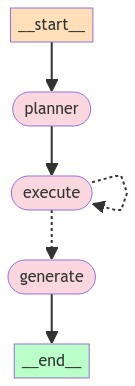

In [16]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())


In [17]:
graph.invoke({"query": "app development using swift"})

Executing step 1: Rewrite the query to optimize it for YouTube - query_rewrite

Executing step 2: Search for videos based on the optimized query - search_videos

Executing step 3: Get the transcripts of the videos - get_transcripts

Executing step 4: Filter out irrelevant videos based on the transcripts - filter_videos

Executing step 5: Generate lesson plans based on the video transcripts - generate_plan


{
    'query': 'app development using swift',
    'plan': PlanningTemplate(
        steps=[
            PlanningStep(
                thought='To ensure the query is optimized for YouTube, I need to rewrite it to be more specific and likely to yield relevant results.',
                action='Rewrite the query to optimize it for YouTube',
                tool='query_rewrite'
            ),
            PlanningStep(
                thought='With the optimized query, I can search for relevant videos on YouTube.',
                action='Search for videos based on the optimized query',
                tool='search_videos'
            ),
            PlanningStep(
                thought='To ensure the videos are relevant to the topic, I will retrieve their transcripts.',
                action='Get the transcripts of the videos',
                tool='get_transcripts'
            ),
            PlanningStep(
                thought='I need to filter out any videos that are not relevant ba